# Social Networks Final Project: Protein-Protein Interactions (PPI)

**Group members:**

Marina Iuliana Aur, *1809715* <br>
Cristiana Di Tullio, *1803880*

## Import libraries and dependencies

In [ ]:
# Run if needed
%pip install torch-geometric
%pip install markov-clustering

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import itertools
import pprint
import torch
from torch.cuda import is_available
from torch_geometric.utils import to_networkx, negative_sampling
import markov_clustering as mc
from scipy.sparse import csr_matrix

In [2]:
# CPU/GPU
device = 'cpu'
if torch.cuda.is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


## Utility functions

In [122]:
# Graph visualization functions from the SNOM Lab
# NOTE: the original input object was not a normal networkx graph
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs = ['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize = (9, 7))
	nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
	plt.show()

In [3]:
def print_dict(string, dictionary, n = 5):
    """
    Utility function to display only the first n elements
    of a dictionary.
    """
    dictionary = dict(dictionary)

    out = dict(itertools.islice(dictionary.items(), n))
    print(string)
    print("-" * len(string))
    pprint.pprint(out)
    print("")

## 1) Introduction


 ### 1.1) Dataset description

 [**BIOGRID CORONAVIRUS dataset**](
https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.236/BIOGRID-CORONAVIRUS-4.4.236.tab3.zip)

 (every row represents the interaction between two proteins)

In [4]:
# Load PPI dataset
#covid_df = pd.read_csv('/content/BIOGRID-CORONAVIRUS-4.4.236.tab3.txt', sep = '\t')
covid_df = pd.read_csv('BIOGRID-CORONAVIRUS-4.4.236.tab3.txt', sep = '\t')
covid_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,141211,850980,852501,31542,32899,YLR274W,YBR202W,MCM5,MCM7,BOB1|CDC46|MCM DNA helicase complex subunit MC...,...,-,NP_009761,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
1,141212,852501,850980,32899,31542,YBR202W,YLR274W,MCM7,MCM5,CDC47|MCM DNA helicase complex subunit MCM7|L0...,...,-,NP_013376,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
2,141213,850980,856680,31542,36697,YLR274W,YEL032W,MCM5,MCM3,BOB1|CDC46|MCM DNA helicase complex subunit MC...,...,-,NP_010882,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
3,141214,856680,850980,36697,31542,YEL032W,YLR274W,MCM3,MCM5,MCM DNA helicase complex subunit MCM3|L000001039,...,-,NP_013376,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
4,141215,852501,850793,32899,31376,YBR202W,YLR103C,MCM7,CDC45,CDC47|MCM DNA helicase complex subunit MCM7|L0...,...,-,NP_013204,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)


In [5]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60777 entries, 0 to 60776
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   #BioGRID Interaction ID             60777 non-null  int64 
 1   Entrez Gene Interactor A            60777 non-null  object
 2   Entrez Gene Interactor B            60777 non-null  object
 3   BioGRID ID Interactor A             60777 non-null  int64 
 4   BioGRID ID Interactor B             60777 non-null  int64 
 5   Systematic Name Interactor A        60777 non-null  object
 6   Systematic Name Interactor B        60777 non-null  object
 7   Official Symbol Interactor A        60777 non-null  object
 8   Official Symbol Interactor B        60777 non-null  object
 9   Synonyms Interactor A               60777 non-null  object
 10  Synonyms Interactor B               60777 non-null  object
 11  Experimental System                 60777 non-null  ob

In [10]:
# Maybe we can focus just on data relative to humans
# (covers 97% of original data anyway)
print('Original organisms in the dataset:\n')
print(pd.concat([covid_df['Organism Name Interactor A'], covid_df['Organism Name Interactor B']]).unique())
print('\n-----------------------\n')
print('After filtering by "Homo sapiens":\n')
# Select only rows whose Organism Interactor A or B is 'Homo sapiens'
human_df = covid_df[(covid_df['Organism Name Interactor A'] == 'Homo sapiens') | (covid_df['Organism Name Interactor B'] == 'Homo sapiens')]
human_df = human_df.reset_index(drop = True)
print(pd.concat([human_df['Organism Name Interactor A'], human_df['Organism Name Interactor B']]).unique())
print('\n-----------------------\n')
print('Datasets size ratio:', human_df.shape[0] / covid_df.shape[0])
print('New dataset dimension:', human_df.shape[0], 'observations')

Original organisms in the dataset:

['Saccharomyces cerevisiae (S288c)' 'Homo sapiens'
 'Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus'
 'Cricetulus griseus'
 'Middle-East Respiratory Syndrome-related Coronavirus' 'Mus musculus'
 'Human Immunodeficiency Virus 1' 'Hepatitus C Virus' 'Bos taurus'
 'Equus caballus' 'Macaca mulatta' 'Sus scrofa' 'Danio rerio'
 'Rattus norvegicus' 'Escherichia coli (K12/MG1655)' 'Myotis lucifugus'
 'Canis familiaris' 'Chlorocebus sabaeus' 'Felis Catus'
 'Oryctolagus cuniculus' 'Schizosaccharomyces pombe (972h)'
 'Drosophila melanogaster' 'Gallus gallus' 'Plasmodium falciparum (3D7)']

-----------------------

After filtering by "Homo sapiens":

['Homo sapiens' 'Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus'
 'Middle-East Respiratory Syndrome-related Coronavirus'
 'Human Immunodeficiency Virus 1' 'Hepatitus C Virus' 'Bos taurus'
 'Mus musculu

In [11]:
#ppi = covid_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
ppi = human_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
ppi.head()

,Official Symbol Interactor A,Official Symbol Interactor B
0,CCND1,ESR1
1,BRCA1,ESR1
2,ESR1,BRCA1
3,ESR1,CCND1
4,CREBBP,IRF3


### 1.2) Network analysis

(including degree, betweenness, closeness, and other relevant metrics)

In [13]:
# Check the shape of the dataframe without duplicates (it will not remove rows with the same genes but in different columns)
#ppi.drop_duplicates().shape
ppi = ppi.drop_duplicates()
ppi.shape

(43679, 2)

In [14]:
ppi_network = nx.from_pandas_edgelist(ppi,
                                      source = "Official Symbol Interactor A",
                                      target = "Official Symbol Interactor B",
                                      create_using = nx.Graph())      # nx.Graph() doesn't allow duplicated edges

print(ppi_network) #the nr of edges is lower than the nr of dataframe rows because of the non extracted duplicates

Graph with 8098 nodes and 43279 edges


In [15]:
# Identify self-loops
self_loops_bio = list(nx.selfloop_edges(ppi_network))
print("Number of self loops: ", len(self_loops_bio))
print("Self-loops over Total edges:", round(nx.number_of_selfloops(ppi_network) / len(ppi_network.edges), 4), "\n")

# Remove self-loops
ppi_network.remove_edges_from(self_loops_bio)
print("Graph without self-loops:", ppi_network)

Number of self loops:  52
Self-loops over Total edges: 0.0012 

Graph without self-loops: Graph with 8098 nodes and 43227 edges


In [16]:
# Isolate the largest connected component (LCC) -> ha senso?
# Va bene, non cambia molto alla fine
components = list(nx.connected_components(ppi_network))
largest_component = max(components, key = len)
LCC_ppi = ppi_network.subgraph(largest_component)
print(LCC_ppi)

Graph with 8086 nodes and 43221 edges


In [57]:
# Compute metrics
degree = LCC_ppi.degree()
bet = nx.betweenness_centrality(LCC_ppi, k = 100, normalized = True) # richiede troppo tempo, per ora normalizzo con k=100
# clos = nx.closeness_centrality(LCC_ppi) -> richiede troppo tempo -> anche con la GPU?

In [58]:
try:
    eigen = nx.eigenvector_centrality(LCC_ppi, max_iter = 500, tol = 1e-04)
except nx.PowerIterationFailedConvergence as e:
    print(f"Failed to converge: {e}")

In [59]:
degree_dict = dict(degree)
ratio = {}

for node in LCC_ppi.nodes():
    if degree_dict[node] > 0:
        ratio[node] = bet[node] / degree_dict[node]
    else:
        ratio[node] = 0

In [62]:
# Insert metrics in the dictionary
nodes = LCC_ppi.nodes()
gene_measures = dict(nodes)

for gene in gene_measures:
    gene_measures[gene]["Degree"] = degree[gene]
    gene_measures[gene]["Betweeness"] = bet[gene]
    #gene_measures[gene]["Closeness"] = clos[gene]
    gene_measures[gene]["Eigen"] = eigen[gene]
    gene_measures[gene]["BetoverDeg"] = ratio[gene]
print_dict("Gene measures:", gene_measures)

Gene measures:
--------------
{'BRCA1': {'BetoverDeg': 1.478749389378583e-06,
           'Betweeness': 2.957498778757166e-06,
           'Degree': 2,
           'Eigen': 0.0007872599949043145},
 'CCND1': {'BetoverDeg': 2.7714531630280975e-05,
           'Betweeness': 0.00013857265815140488,
           'Degree': 5,
           'Eigen': 0.0014657085497142622},
 'CREBBP': {'BetoverDeg': 8.30401431241802e-06,
            'Betweeness': 4.9824085874508116e-05,
            'Degree': 6,
            'Eigen': 0.0023171570767074397},
 'ESR1': {'BetoverDeg': 1.1756159911790262e-05,
          'Betweeness': 4.7024639647161046e-05,
          'Degree': 4,
          'Eigen': 0.0017579558160018855},
 'IRF3': {'BetoverDeg': 1.2496168437582057e-05,
          'Betweeness': 0.00018744252656373086,
          'Degree': 15,
          'Eigen': 0.003832487618086831}}



In [63]:
# Build a metrics dataframe
measures_ppi = pd.DataFrame.from_dict(gene_measures, orient ='index')
measures_ppi = measures_ppi.reset_index()
measures_ppi.rename(columns={'index': 'Gene'}, inplace = True)

# Sort the output
sorted_metrics = measures_ppi.sort_values(by = 'Degree', ascending = False)
sorted_metrics.reset_index(drop = True, inplace = True)
sorted_metrics['Ranking'] = sorted_metrics.index + 1
sorted_metrics.set_index('Ranking', inplace = True)

# Visualize the output
sorted_metrics.head()

,Gene,Degree,Betweeness,Eigen,BetoverDeg
Ranking,,,,,
1,M,2068,0.128973,0.239406,0.000062
2,ORF7b,1755,0.081155,0.213850,0.000046
3,nsp6,1684,0.039153,0.211439,0.000023
4,N,1507,0.097550,0.106208,0.000065
5,nsp4,1483,0.047868,0.203859,0.000032


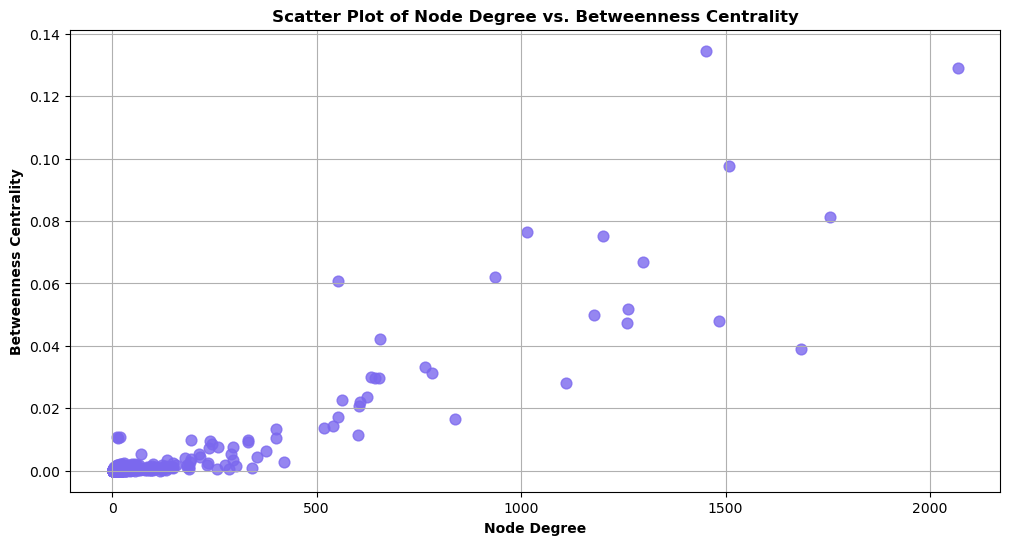

In [64]:
# Scatterplot of degree vs betweeness
x = measures_ppi['Degree']
y = measures_ppi['Betweeness']

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color = 'mediumslateblue', alpha = 0.8, s = 60)

plt.title('Scatter Plot of Node Degree vs. Betweenness Centrality', fontweight='bold')
plt.xlabel('Node Degree', fontweight='bold')
plt.ylabel('Betweenness Centrality', fontweight='bold')
plt.grid()
plt.show()

In [86]:
# Average degree and degree distribution
print('\nAverage degree:', np.mean(sorted_metrics.Degree))
print('\n-----------------------')
fig = px.histogram(sorted_metrics.Degree,
                   nbins = len(sorted_metrics.Degree.unique()),
                   title = 'Degree distribution')
fig.update_layout(xaxis_title = 'degree', yaxis_title = 'count', bargap = 0.2)
fig.update_traces(marker_color = 'mediumslateblue')
fig.show()


Average degree: 10.69032896364086

-----------------------


### 1.3) Network visualization

In [ ]:
# Plot the PPI Largest Connected Component -> troppo grande?
pos = nx.spring_layout(LCC_ppi, seed=42)

plt.clf()
plt.figure(figsize = (14, 10))
nx.draw(LCC_ppi, pos, with_labels = True, node_color = 'violet', node_size = 1000,
        edge_color = 'gray', linewidths = 1, font_size = 16)

plt.title("PPI Largest connected Component Network", fontweight = 'bold')
plt.show()

In [ ]:
# CAREFUL
# Takes a while to plot
plt.figure(figsize = (9, 7))
nx.draw_spring(LCC_ppi, node_size = 30, arrows = False, node_color = 'mediumslateblue')
plt.title('Protein-Protein Interaction Network')
plt.show()

$\textcolor{red}{TO-DO:}$ it still takes too much to run. Try to run it in Colab with the GPU. 

## 2) Community detection

Experimenting with clustering algorithms to investigate if proteins within the same cluster are more likely to interact with each other than with proteins in other clusters.

- KWIKCLUSTER/PIVOT algorithm
- Markov Cluster algorithm
- Louvain algorithm

### 2.1) KWIKCLUSTER (or PIVOT) Algorithm

### 2.2) Markov Cluster Algorithm

In [ ]:
# Run MCL with inflation parameter = 1.8 -> problemi da risolvere
matrix = nx.to_scipy_sparse_array(LCC_ppi)
result = mc.run_mcl(matrix, inflation = 1.8)
clusters = mc.get_clusters(result)

### 2.3) Louvain Algorithm

In [17]:
# Run the Louvain algorithm with gamma = 1
louvain_communities = nx.community.louvain_communities(LCC_ppi, weight = 'weight', resolution = 1.0, seed = 42)

In [18]:
print("Number of Louvain Communities: ", len(louvain_communities))

Number of Louvain Communities:  9


In [19]:
print("First Community 15 Genes: \n")
genes_list = list(louvain_communities[0])
for gene in genes_list[:15]:
    print(gene)

First Community 15 Genes: 

FAM103A1
TRIM47
CISD3
AGT
SREBF1
HIST1H2AA
MIR223
TRAF4
PHLDB1
LANCL2
DMD
ACAT2
AXIN2
LYPLA2
LRRC15


In [20]:
louvain_community_map = {}
for idx, community in enumerate(louvain_communities):
    for node in community:
        louvain_community_map[node] = idx

In [21]:
colors = [louvain_community_map[node] for node in LCC_ppi.nodes()]

In [24]:
pos = nx.spring_layout(LCC_ppi)
plt.figure(figsize = (12, 10))
nx.draw_networkx_nodes(LCC_ppi, pos, node_color = colors, cmap = plt.get_cmap('Set1'), node_size = 50)
nx.draw_networkx_edges(LCC_ppi, pos, alpha = 0.5)
plt.title('Louvain Communities Network')
plt.show()

## 3) Link Prediction with Graph Neural Networks (GNNs)

 ### 3.1) Exploring different models to perform the prediction task

 GAT, GCN, etc.

 Transformers?

### 3.2) Evaluation of results

(using metrics such as confusion matrix, accuracy, precision, recall, F1 score, hits@k, etc.)

## [Optional: Influence and Homophily?]

For any experiment in this area, we can take into consideration the Organism Interactor name as the "class" to which the proteins belong. Remember that in this dataset every row represent an interaction between two proteins, and we have both names of their organisms. We might need to build a new graph containing this information (the one we use for community detection just contains the protein names).

## 4) Conclusions